# Random Forest

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
import numpy as np


df = pd.read_csv("/content/admissions_processed.csv")

rank_cols = ["cs_rank", "eng_rank", "mba_rank", "gen_rank"]
for col in rank_cols:
    if col in df.columns:
        df[col] = df[col].replace(9999, np.nan)
        df[f"{col}_missing"] = df[col].isna().astype(int)

y = df["admission_result"]
drop_cols = [
    "admission_result",
    "student_name",
    "student_id",
    "id",
    "gpa",
    "gpa_scale","scholarship_currency"
]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])

if "application_status" in X.columns:
    X = X.drop(columns=["application_status"])

numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = [c for c in X.columns if c not in numeric_features]


X[categorical_features] = X[categorical_features].astype(str)

print("Numeric features:", list(numeric_features))
print("Categorical features:", list(categorical_features))


numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced",
)
model_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("rf", rf),
])

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)


model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)
y_proba = model_rf.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

ohe = model_rf.named_steps["preprocess"].named_transformers_["cat"].named_steps["ohe"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numeric_features, cat_feature_names])

importances = model_rf.named_steps["rf"].feature_importances_

fi_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances,
})

fi_df = fi_df.sort_values("importance", ascending=False)

print("\n=== Top 20 Random Forest feature importances ===")
print(fi_df.head(20))


/tmp/ipython-input-1459436039.py:14: DtypeWarning: Columns (15,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/admissions_processed.csv")


Numeric features: ['application_year', 'gpa_normalized', 'gpa_missing', 'undergrad_missing', 'toefl', 'ielts', 'english_test_normalized', 'english_missing', 'gre_total', 'gre_verbal', 'gre_quant', 'gre_awa', 'work_experience', 'relevant_work_experience', 'internship_experience', 'publications', 'scholarship_amount', 'cs_rank', 'cs_rank_missing', 'eng_rank', 'eng_rank_missing', 'mba_rank', 'mba_rank_missing', 'gen_rank', 'gen_rank_missing', 'major_alignment', 'total_experience', 'has_publications', 'is_fall_term', 'academic_alignment_score', 'composite_academic_score', 'student_type_encoded', 'has_scholarship_encoded', 'application_term_encoded']
Categorical features: ['student_type', 'university_name', 'university_name_stripped', 'course_name', 'credential', 'credential_standardized', 'categorical_course_name', 'target_degree', 'application_term', 'undergrad_major', 'ug_major_bucket', 'undergrad_university', 'undergrad_canonical', 'undergrad_canonical_stripped', 'gre_missing', 'has_sch

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


In [4]:

y_proba_rf = model_rf.predict_proba(X_test)[:, 1]


In [5]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"Random Forest AUC: {auc_rf:.3f}")

Random Forest AUC: 0.862


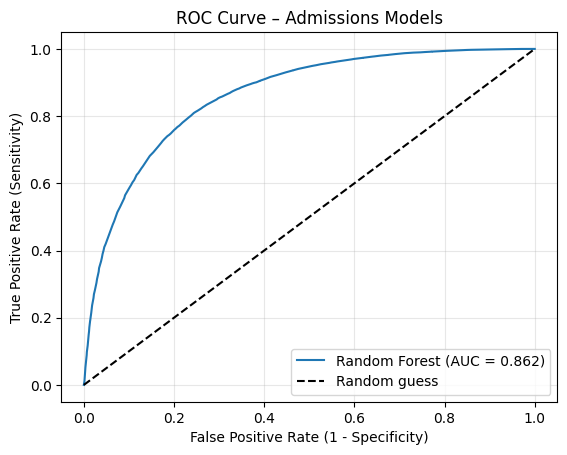

In [6]:
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve – Admissions Models")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

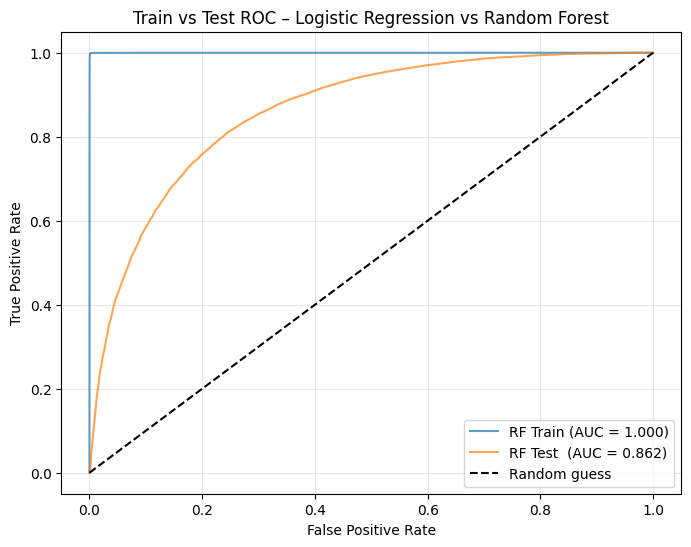

In [7]:

y_proba_rf_train = model_rf.predict_proba(X_train)[:, 1]
fpr_rf_tr, tpr_rf_tr, _ = roc_curve(y_train, y_proba_rf_train)
auc_rf_tr = roc_auc_score(y_train, y_proba_rf_train)
plt.figure(figsize=(8, 6))

plt.plot(fpr_rf_tr, tpr_rf_tr, label=f"RF Train (AUC = {auc_rf_tr:.3f})", alpha=0.7)
plt.plot(fpr_rf,    tpr_rf,    label=f"RF Test  (AUC = {auc_rf:.3f})",    alpha=0.7)

plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train vs Test ROC – Logistic Regression vs Random Forest")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


Random Forest AUC (train): 1.000
Random Forest AUC (test):  0.862


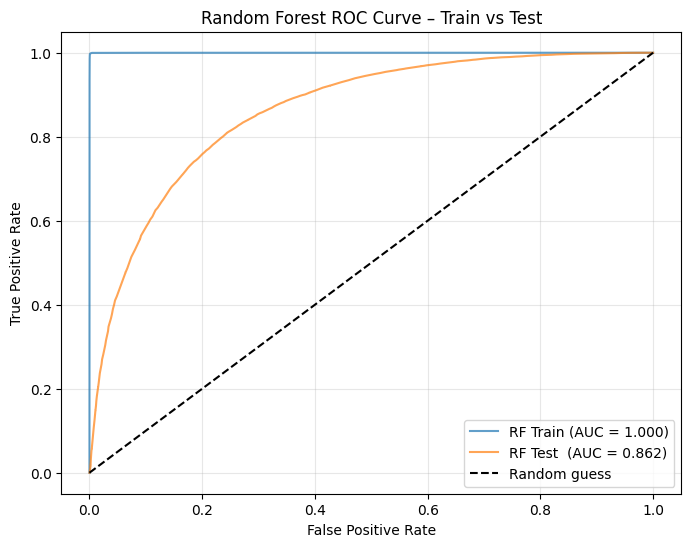

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_proba_rf_train = model_rf.predict_proba(X_train)[:, 1]
y_proba_rf_test  = model_rf.predict_proba(X_test)[:, 1]


fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, y_proba_rf_train)
fpr_rf_test,  tpr_rf_test,  _ = roc_curve(y_test,  y_proba_rf_test)

auc_rf_train = roc_auc_score(y_train, y_proba_rf_train)
auc_rf_test  = roc_auc_score(y_test,  y_proba_rf_test)

print(f"Random Forest AUC (train): {auc_rf_train:.3f}")
print(f"Random Forest AUC (test):  {auc_rf_test:.3f}")

plt.figure(figsize=(8, 6))

plt.plot(fpr_rf_train, tpr_rf_train, label=f"RF Train (AUC = {auc_rf_train:.3f})", alpha=0.7)
plt.plot(fpr_rf_test,  tpr_rf_test,  label=f"RF Test  (AUC = {auc_rf_test:.3f})",  alpha=0.7)


plt.plot([0, 1], [0, 1], "k--", label="Random guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve – Train vs Test")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


# To avoid Overfitting the below model has been tuned

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
import numpy as np

df = pd.read_csv("/content/admissions_processed.csv")
rank_cols = ["cs_rank", "eng_rank", "mba_rank", "gen_rank"]
for col in rank_cols:
    if col in df.columns:
        df[col] = df[col].replace(9999, np.nan)
        df[f"{col}_missing"] = df[col].isna().astype(int)

y = df["admission_result"]
drop_cols = [
    "admission_result",
    "student_name",
    "student_id",
    "id",
    "gpa",
    "gpa_scale","scholarship_currency"
]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])


if "application_status" in X.columns:
    X = X.drop(columns=["application_status"])


numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = [c for c in X.columns if c not in numeric_features]


X[categorical_features] = X[categorical_features].astype(str)

print("Numeric features:", list(numeric_features))
print("Categorical features:", list(categorical_features))


numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    bootstrap=True,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced",
)

model_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("rf", rf),
])


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)
y_proba = model_rf.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


ohe = model_rf.named_steps["preprocess"].named_transformers_["cat"].named_steps["ohe"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numeric_features, cat_feature_names])

importances = model_rf.named_steps["rf"].feature_importances_

fi_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances,
})

fi_df = fi_df.sort_values("importance", ascending=False)

print("\n=== Top 20 Random Forest feature importances ===")
print(fi_df.head(20))


/tmp/ipython-input-1248636415.py:11: DtypeWarning: Columns (15,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/admissions_processed.csv")


Numeric features: ['application_year', 'gpa_normalized', 'gpa_missing', 'undergrad_missing', 'toefl', 'ielts', 'english_test_normalized', 'english_missing', 'gre_total', 'gre_verbal', 'gre_quant', 'gre_awa', 'work_experience', 'relevant_work_experience', 'internship_experience', 'publications', 'scholarship_amount', 'cs_rank', 'cs_rank_missing', 'eng_rank', 'eng_rank_missing', 'mba_rank', 'mba_rank_missing', 'gen_rank', 'gen_rank_missing', 'major_alignment', 'total_experience', 'has_publications', 'is_fall_term', 'academic_alignment_score', 'composite_academic_score', 'student_type_encoded', 'has_scholarship_encoded', 'application_term_encoded']
Categorical features: ['student_type', 'university_name', 'university_name_stripped', 'course_name', 'credential', 'credential_standardized', 'categorical_course_name', 'target_degree', 'application_term', 'undergrad_major', 'ug_major_bucket', 'undergrad_university', 'undergrad_canonical', 'undergrad_canonical_stripped', 'gre_missing', 'has_sch

In [13]:
model_rf.fit(X_train, y_train)

from sklearn.metrics import roc_auc_score, roc_curve

y_proba_train = model_rf.predict_proba(X_train)[:, 1]
y_proba_test  = model_rf.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_train, y_proba_train)
auc_test  = roc_auc_score(y_test,  y_proba_test)

print("Train AUC:", auc_train)
print("Test  AUC:", auc_test)


Train AUC: 0.8944558963139451
Test  AUC: 0.832258198665388


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ohe_rf = model_rf.named_steps["preprocess"].named_transformers_["cat"].named_steps["ohe"]
cat_feature_names_rf = ohe_rf.get_feature_names_out(categorical_features)
all_feature_names_rf = np.concatenate([numeric_features, cat_feature_names_rf])

importances_rf = model_rf.named_steps["rf"].feature_importances_

fi_rf_df = pd.DataFrame({
    "feature": all_feature_names_rf,
    "importance": importances_rf,
})

fi_rf_df = fi_rf_df.sort_values("importance", ascending=False)
fi_rf_df.head(20)


,feature,importance
23,gen_rank,0.056600
17,cs_rank,0.043106
25079,university_tier_Top_50,0.039843
1,gpa_normalized,0.018130
19,eng_rank,0.017907
30,composite_academic_score,0.014822
25076,university_tier_Others,0.013305
0,application_year,0.012974
8,gre_total,0.011750
25078,university_tier_Top_200,0.010737


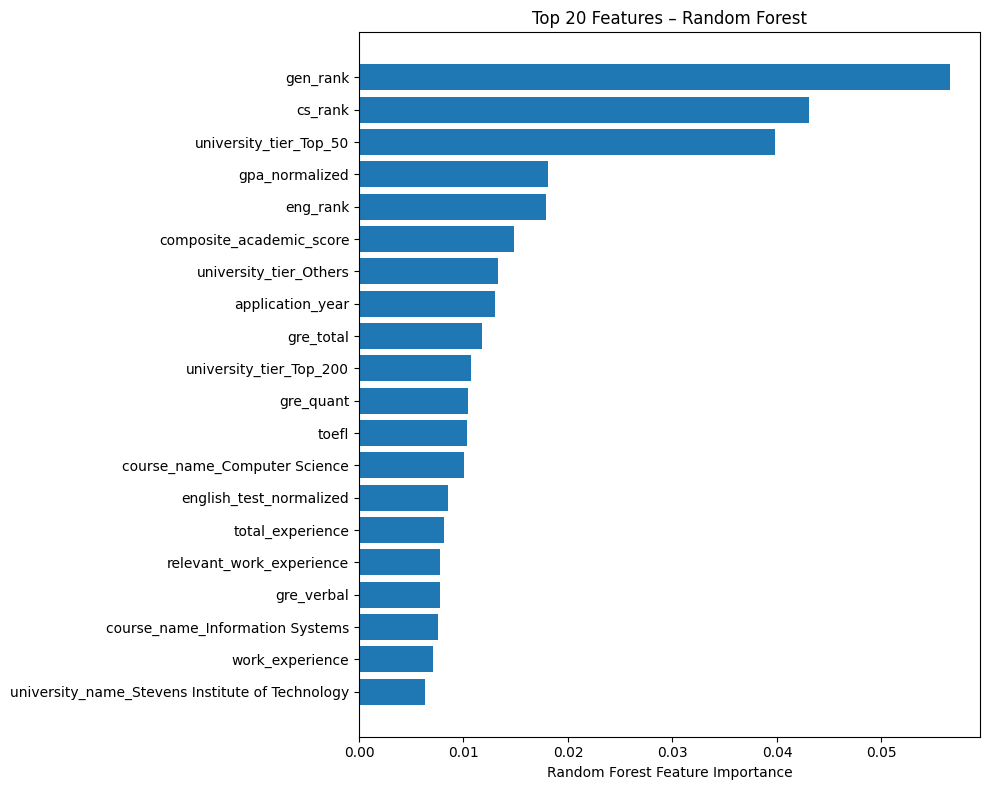

In [15]:
top_n = 20
top_rf = fi_rf_df.head(top_n).iloc[::-1]
plt.figure(figsize=(10, 8))
plt.barh(top_rf["feature"], top_rf["importance"])
plt.xlabel("Random Forest Feature Importance")
plt.title(f"Top {top_n} Features – Random Forest")
plt.tight_layout()
plt.show()


In [7]:


# We'll use the probabilities we already computed on X_test: y_proba (P(admit=1))
meta_cols = [
    "student_id",
    "student_name",
    "university_name",
    "course_name",
    "university_tier",
    "application_term",
    "application_year",
]

available_meta_cols = [c for c in meta_cols if c in df.columns]

results_test = df.loc[X_test.index, available_meta_cols].reset_index(drop=True)
results_test["p_admit"] = y_proba


def bucket_simple(p):

    if p >= 0.7:
        return "safe"
    elif p >= 0.4:
        return "target"
    else:
        return "ambitious"

results_test["bucket_simple"] = results_test["p_admit"].apply(bucket_simple)

def bucket_with_tier(row):
    p = row["p_admit"]
    tier = row.get("university_tier", None)
    if tier is None or pd.isna(tier):
        return bucket_simple(p)


    if tier == "Top_20":
        if p >= 0.7:
            return "target"
        elif p >= 0.4:
            return "reach/target"
        else:
            return "ambitious"

    return bucket_simple(p)

if "university_tier" in results_test.columns:
    results_test["bucket"] = results_test.apply(bucket_with_tier, axis=1)
else:
    results_test["bucket"] = results_test["bucket_simple"]

print("\n Bucket distribution")
print(results_test["bucket"].value_counts(normalize=True))

N = 20
reach_df = results_test[results_test["bucket"].str.startswith("reach")].sort_values(
    "p_admit", ascending=False
)
target_df = results_test[results_test["bucket"] == "target"].sort_values(
    "p_admit", ascending=False
)
safe_df = results_test[results_test["bucket"] == "safe"].sort_values(
    "p_admit", ascending=False
)

plan = pd.concat(
    [
        reach_df.head(6),
        target_df.head(6),
        safe_df.head(6),
    ],
    ignore_index=True,
).head(N)

plan_cols = [
    c
    for c in [
        "student_id",
        "student_name",
        "university_name",
        "course_name",
        "university_tier",
        "application_term",
        "application_year",
        "p_admit",
        "bucket",
    ]
    if c in plan.columns
]

print("\n Recommended application plan ")
display(plan[plan_cols])


 Bucket distribution
bucket
target       0.558604
ambitious    0.222293
safe         0.219103
Name: proportion, dtype: float64

 Recommended application plan 


,student_id,student_name,university_name,course_name,university_tier,application_term,application_year,p_admit,bucket
0,669292,Raja Avinash,University of Findlay,Health Informatics,Others,fall,2021,0.699984,target
1,1317909,Vamsi Krishna,The University of Central Missouri,Data Science and Artificial Intelligence,Others,spring,2026,0.699981,target
2,474563,Gopichowdary Marella,University of New Haven,Mechanical Engineering,Others,fall,2019,0.699972,target
3,1341620,Abhishek Kandukuri,Arizona State University,Business Analytics,Top_200,spring,2025,0.699950,target
4,429622,Roop Sai K,University of South Florida,Artificial Intelligence (AI) and Business Anal...,Top_100,fall,2020,0.699950,target
5,364961,Nitesh Wagh,"California State University, Fullerton",Electrical Engineering,Others,fall,2018,0.699923,target
6,1503281,Charmi Mehta,Stevens Institute of Technology,Engineering Management,Top_100,fall,2025,0.928379,safe
7,604964,Anuroop John Abraham,Stevens Institute of Technology,Computer Science,Top_100,fall,2021,0.927230,safe
8,1101391,Srinwanti Ss,Stevens Institute of Technology,Data Science,Top_100,fall,2023,0.923694,safe
9,1264575,Indu Sai Atla,The University of Texas at Dallas,Financial Technology and Analytics,Top_200,fall,2024,0.921275,safe
